c:\Users\92803\.conda\envs\rl_hw\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\92803\.conda\envs\rl_hw\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\92803\.conda\envs\rl_hw\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


0.2 0 Family2.owl
precision:  0.7315705128205128
recall:  0.30038653857707187
0.2 0 glycordf.glycordf.14.owl.xml
precision:  0.775
recall:  0.5057915464165463
0.2 0 nifdys.neuroscience-information-framework-nif-dysfunction-ontlogy.14.owl.xml
precision:  0.05
recall:  0.045588235294117645
0.2 0 nihss.national-institutes-of-health-stroke-scale-ontology.11.owl.xml
precision:  1.0
recall:  0.6472222222222221
0.2 0 ontodm-core.ontology-of-core-data-mining-entities.6.owl.xml
precision:  0.0
recall:  0.0
0.2 0 sso.syndromic-surveillance-ontology.1.owl.xml
precision:  1.0
recall:  0.8126623376623376
0.2 1 Family2.owl
precision:  0.0463768115942029
recall:  0.02508333333333333
0.2 1 glycordf.glycordf.14.owl.xml
precision:  0.0
recall:  0.0
0.2 1 nifdys.neuroscience-information-framework-nif-dysfunction-ontlogy.14.owl.xml
precision:  0.05
recall:  0.046078431372549015
0.2 1 nihss.national-institutes-of-health-stroke-scale-ontology.11.owl.xml
precision:  0.0
recall:  0.0
0.2 1 ontodm-core.ontolog

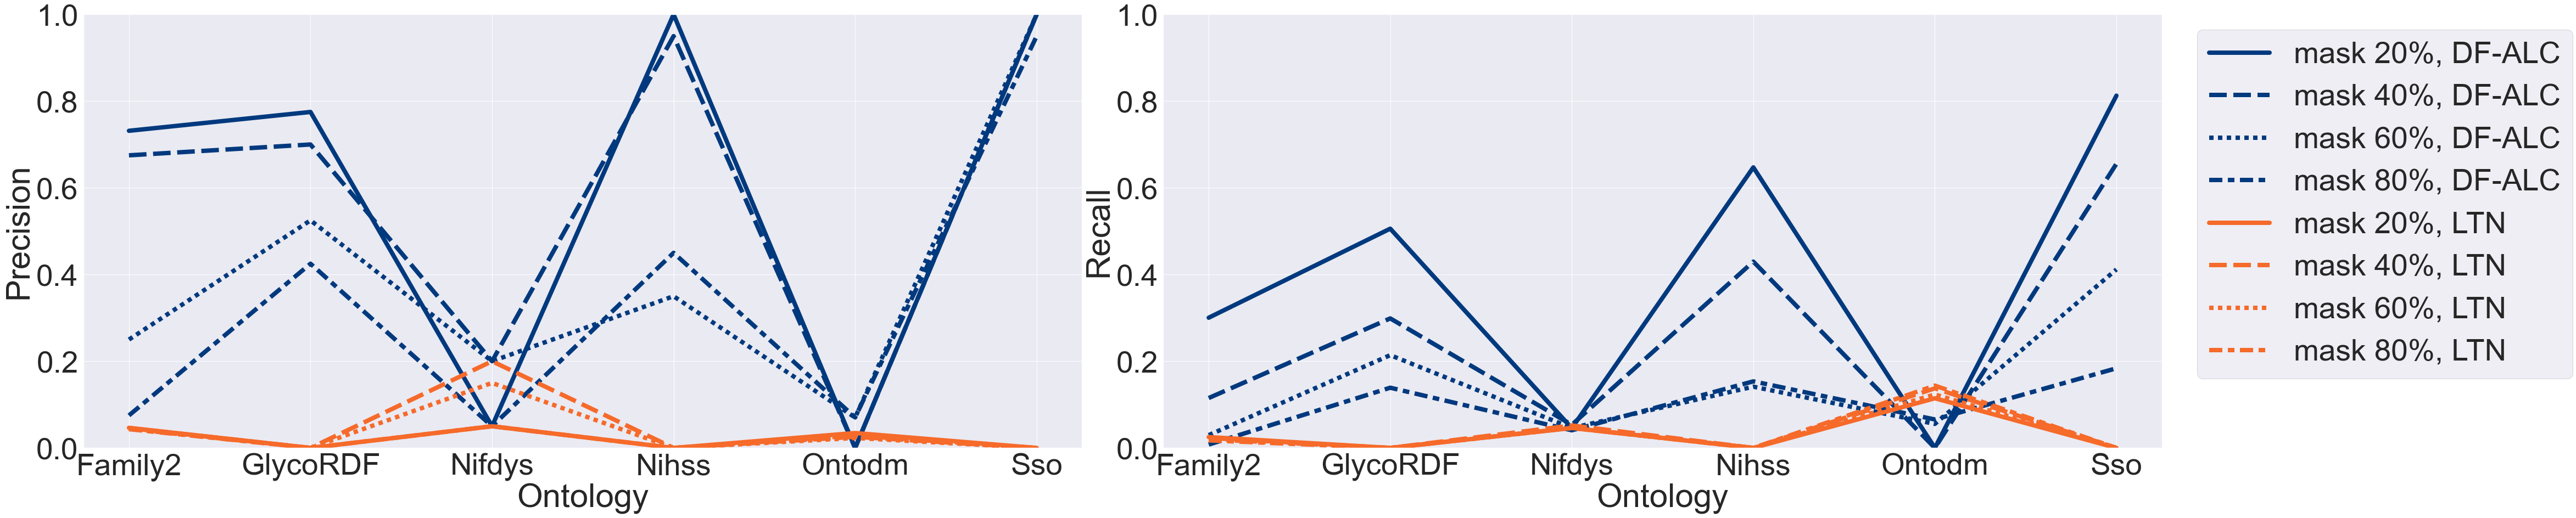

In [1]:
%matplotlib inline
# Evaluate with CQA task and show the results
import matplotlib.pyplot as plt

import pickle
import numpy as np
from Evaluation import CQAnswering
from model import DFALC
import torch
import seaborn as sns 
import pandas as pd
device = torch.device("cpu")
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(font_scale=5)
depth=2

base_names = [
    # 'Family.owl',
    'Family2.owl',
    'glycordf.glycordf.14.owl.xml',
    'nifdys.neuroscience-information-framework-nif-dysfunction-ontlogy.14.owl.xml',
    'nihss.national-institutes-of-health-stroke-scale-ontology.11.owl.xml',
    'ontodm-core.ontology-of-core-data-mining-entities.6.owl.xml',
    'sso.syndromic-surveillance-ontology.1.owl.xml',
]
names = ["Family2","GlycoRDF","Nifdys","Nihss","Ontodm","Sso"]
our_precision = []
ltn_precision = []
our_recall = []
ltn_recall = []
model_name = ["Godel","LTN"]
for rate in [0.2,0.4,0.6,0.8]:
    out_pathes = ["output_alpha0.8/mask_"+str(rate)+"/","product_output_alpha0.8/mask_"+str(rate)+"/"]
    info_path = "output_alpha0.8/mask_"+str(rate)+"/"
    for idx, out_path in enumerate(out_pathes):
        for file_name in base_names:
            print(rate, idx, file_name)
            cEmb = pickle.load(open(out_path+file_name+".cEmb.pkl","rb"))
            rEmb = pickle.load(open(out_path+file_name+".rEmb.pkl","rb"))
            masked_cEmb = np.load(open(info_path+file_name+".masked_cEmb.npy","rb"))
            masked_rEmb = np.load(open(info_path+file_name+".masked_rEmb.npy","rb"))
            true_cEmb = np.load(open(info_path+file_name+".true_cEmb.npy","rb"))
            true_rEmb = np.load(open(info_path+file_name+".true_rEmb.npy","rb"))
            c2id = pickle.load(open(info_path+file_name+".c2id.pkl","rb"))
            r2id = pickle.load(open(info_path+file_name+".r2id.pkl","rb"))
            i2id = pickle.load(open(info_path+file_name+".i2id.pkl","rb"))
            id2c = {i:c for c,i in c2id.items()}
            id2r = {i:c for c,i in r2id.items()}
            id2i = {i:c for c,i in i2id.items()}

            model = DFALC({}, len(c2id), len(r2id), masked_cEmb, masked_rEmb, device,name=model_name[idx]).to(device)
            cqa = CQAnswering("input/"+file_name+".depth_"+str(depth)+".queries", "input/"+file_name+".depth_"+str(depth)+".answers", c2id, r2id, i2id)
            precision, recall = cqa.get_score(model, torch.tensor(cEmb), torch.tensor(rEmb), alpha=0.8)
            if idx == 0:
                our_precision.append(precision)
                our_recall.append(recall)
            else:
                ltn_precision.append(precision)
                ltn_recall.append(recall)
            print("precision: ", precision)
            print("recall: ", recall)
our_data = pd.DataFrame(np.array([our_precision,our_recall,['mask {:.0f}%, DF-ALC'.format(0.2*(i//(len(base_names))+1)*100) for i in range(len(base_names)*4)],names*4]).T, columns = ["Precision","Recall","mask_rate","Ontology"])
our_data["Precision"] = our_data["Precision"].astype("float")
our_data["Recall"] = our_data["Recall"].astype("float")
ltn_data = pd.DataFrame(np.array([ltn_precision,ltn_recall,['mask {:.0f}%, LTN'.format(0.2*(i//(len(base_names))+1)*100) for i in range(len(base_names)*4)],names*4]).T, columns = ["Precision","Recall","mask_rate","Ontology"])
ltn_data["Precision"] = ltn_data["Precision"].astype("float")
ltn_data["Recall"] = ltn_data["Recall"].astype("float")
fig, axes = plt.subplots(1,2,figsize=(65,13))
axes1, axes2 = axes.flatten()
ax1=sns.lineplot(data=our_data,x="Ontology",y="Precision",hue="mask_rate",palette=["#00397E"]*4,style="mask_rate",ax=axes1,legend=False,linewidth=8)
ax2=sns.lineplot(data=ltn_data,x="Ontology",y="Precision",hue="mask_rate",palette=["#F66A2A"]*4,style="mask_rate",ax=axes1,legend=False,linewidth=8)
ax1.set(ylim=(0,1))
ax3=sns.lineplot(data=our_data,x="Ontology",y="Recall",hue="mask_rate",palette=["#00397E"]*4,style="mask_rate",ax=axes2,linewidth=8)
ax4=sns.lineplot(data=ltn_data,x="Ontology",y="Recall",hue="mask_rate",palette=["#F66A2A"]*4,style="mask_rate",ax=axes2,linewidth=8)
ax3.set(ylim=(0,1))
leg = plt.legend(bbox_to_anchor=(1.02,1),loc="upper left")
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
plt.tight_layout(pad=0.05)
# ax2.set(ylim=(0,1))
# plt.show()
fig.savefig("cqa.png",dpi=400)